In [1]:
!pip install langchain
!pip install langchain-chroma
!pip install -U langchain-community
!pip install tiktoken
!pip install unstructured

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.4/189.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 10.2 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=cbe7ba4a87c515b7b493d8ab59f5431b0c9fa12a2ea2b04d7786c008f148a95d
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4b

In [2]:
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub


In [3]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app

/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app


In [6]:
!ls

df.csv			   MutualFundSummary1
df_main.csv		   MutualFundSummary10
df_RAG2_5.csv		   MutualFundSummary2
df_RAG2.csv		   MutualFundSummary2_5
df_RAG3_5.csv		   MutualFundSummary3
df_RAG3.csv		   MutualFundSummary3_5
df_RAG4.csv		   MutualFundSummary4
df_RAG_all.csv		   MutualFundSummary4_5
df_RAG.csv		   MutualFundSummary5
df_summary.csv		   MutualFundSummary6
docs			   MutualFundSummary7
FundArticlesHealthy.csv    MutualFundSummary8
FundArticlesUnhealthy.csv  MutualFundSummary9
glove.6B.50d.txt	   NLP_Deep_Learning_Questrom_WS_03_2020.ipynb
MutualFundLabels.csv	   word2vec_MutualFundSummary.txt
MutualFundSummary	   word2vec_perso.txt


In [7]:
DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

HEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesHealthy.csv")
UNHEALTHY_ARTICLES_PATH = os.path.join(DIRECTORY, "Data", "FundArticlesUnhealthy.csv")

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'
new_word2vec = 'word2vec_MutualFundSummary.txt'

In [8]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    #with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
    with open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [9]:
# Get the summaries
fund_names, summaries = get_data(SUMMARY_PATH)

In [10]:
len(fund_names)

545

In [11]:
len(summaries)

545

In [12]:
fund_names[20]

'AB Municipal Bond Inflation Strategy'

In [13]:
type(summaries), type(fund_names)

(list, list)

In [14]:
df_summary = pd.read_csv('df_summary.csv')
df_summary

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,Ivestment_Strategy_label,Predicted investment strategy,investment strategy evidence,source meta data,Prediction
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2018 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2021 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2024 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2027 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2030 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
427,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Corporate Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0
428,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Municipal Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0
429,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,0.0,Equity Long Only (Low Risk),American Century Quality Diversified Internati...,{'source': 'MutualFundSummary/American Century...,0.0
430,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,0.0,Equity Long Only (Low Risk),American Century STOXX U.S. Quality Growth ETF...,{'source': 'MutualFundSummary/American Century...,0.0


In [15]:
common_fund_names = []
for index, name in enumerate(fund_names):
    # Check if the current fund name is in the set of common names
    if name in set(df_summary['fund_name']):
        # If it is, append the corresponding summary (using the same index)
        common_fund_names.append(fund_names[index])
len(common_fund_names)

432

In [16]:
common_summaries = []
for index, name in enumerate(fund_names):
    # Check if the current fund name is in the set of common names
    if name in set(df_summary['fund_name']):
        # If it is, append the corresponding summary (using the same index)
        common_summaries.append(summaries[index])
len(common_summaries)

432

In [17]:
#checking
common_fund_names[1]

'ALL CAP GROWTH FUND'

In [18]:
common_summaries[1]

'Fund Summary\nInvestment Objective\nThe fund seeks long-term capital growth.\nFees and Expenses\nThe following table describes the fees and expenses you may pay if you buy and hold shares of the fund. You may qualify for sales charge discounts if you and your family invest, or agree to invest in the future, at least $50,000 in American Century Investments funds. More information about these and other discounts is available from your financial professional and in Calculation of Sales Charges on page 12 of the fund’s prospectus, Appendix A of the fund’s prospectus and Sales Charges in Appendix B of the statement of additional information.\nShareholder Fees (fees paid directly from your investment)\n \n \nInvestor\nI1\nA\nC\nR\nMaximum Sales Charge (Load) Imposed on\nPurchases (as a percentage of offering price)\nNone\nNone\n5.75%\nNone\nNone\nMaximum Deferred Sales Charge (Load)\n(as a percentage of the lower of the original\noffering price or redemption proceeds when redeemed\nwithin o

## split to train, validation, test

In [19]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    common_summaries, common_fund_names, test_size=0.3, random_state=815)

In [20]:
#split to test and validation set
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42)

In [21]:
len(X_train), len(X_val), len(X_test)

(302, 65, 65)

## (Other method)

In [ ]:
#creating a dataframe that includes fund_names and summaries
prospectus = {
    'fund_name': fund_names,
    'Summary': summaries
}

df_prospectus = pd.DataFrame(prospectus)

In [ ]:
df_prospectus

,fund_name,Summary
0,AB Arizona Portfolio,AB Arizona Portfolio\n------------------------...
1,AB Asia ex-Japan Equity Portfolio,AB ASIA EX-JAPAN EQUITY PORTFOLIO\n-----------...
2,AB Credit Long/Short Portfolio,AB CREDIT LONG/SHORT PORTFOLIO\n--------------...
3,AB Balanced Wealth Strategy Portfolio,AB VPS BALANCED WEALTH STRATEGY PORTFOLIO\n---...
4,AB Bond Inflation Strategy,SUMMARY INFORMATION\n-------------------------...
...,...,...
540,Variable Portfolio - Victory Sycamore Establis...,SUMMARY OF CTIVPSM – VICTORY SYCAMORE ESTABLIS...
541,Variable Portfolio - TCW Core Plus Bond Fund,SUMMARY OF CTIVPSM – TCW CORE PLUS BOND FUND\n...
542,Western Asset Intermediate Maturity New York M...,Investment objective\n\nThe fund seeks to prov...
543,Western Asset Massachusetts Municipals Fund,Investment objective\n\nThe fund seeks to prov...


In [ ]:
#merge the table with ground truth
#inner join on fund_name
df_summary = pd.read_csv("df_summary.csv")
df_summary

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,Ivestment_Strategy_label,Predicted investment strategy,investment strategy evidence,source meta data,Prediction
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2018 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2021 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2024 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2027 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2030 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
427,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Corporate Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0
428,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Municipal Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0
429,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,0.0,Equity Long Only (Low Risk),American Century Quality Diversified Internati...,{'source': 'MutualFundSummary/American Century...,0.0
430,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,0.0,Equity Long Only (Low Risk),American Century STOXX U.S. Quality Growth ETF...,{'source': 'MutualFundSummary/American Century...,0.0


In [ ]:
df_main = df_summary.merge(df_prospectus, on='fund_name', how='inner')
df_main

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,Ivestment_Strategy_label,Predicted investment strategy,investment strategy evidence,source meta data,Prediction,Summary
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2018 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0,American Funds College 2018 Fund\n\nInvestment...
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2021 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0,American Funds College 2021 Fund\n\nInvestment...
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2024 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0,American Funds College 2024 Fund\n\nInvestment...
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2027 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0,American Funds College 2027 Fund\n\nInvestment...
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2030 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0,American Funds College 2030 Fund\n\nInvestment...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Corporate Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0,Fund Summary\nInvestment Objective\nThe fund s...
428,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Municipal Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0,Fund Summary\nInvestment Objective\nThe fund s...
429,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,0.0,Equity Long Only (Low Risk),American Century Quality Diversified Internati...,{'source': 'MutualFundSummary/American Century...,0.0,Fund Summary\nInvestment Objective\nThe fund s...
430,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,0.0,Equity Long Only (Low Risk),American Century STOXX U.S. Quality Growth ETF...,{'source': 'MutualFundSummary/American Century...,0.0,Fund Summary\nInvestment Objective\nThe fund s...


In [ ]:
#we treat prediction from RAG as our ground truth
df_main = df_main[['fund_name', 'Summary','Prediction']]
df_main

,fund_name,Summary,Prediction
0,American Funds College 2018 Fund,American Funds College 2018 Fund\n\nInvestment...,2.0
1,American Funds College 2021 Fund,American Funds College 2021 Fund\n\nInvestment...,2.0
2,American Funds College 2024 Fund,American Funds College 2024 Fund\n\nInvestment...,2.0
3,American Funds College 2027 Fund,American Funds College 2027 Fund\n\nInvestment...,2.0
4,American Funds College 2030 Fund,American Funds College 2030 Fund\n\nInvestment...,2.0
...,...,...,...
427,American Century Diversified Corporate Bond ETF,Fund Summary\nInvestment Objective\nThe fund s...,1.0
428,American Century Diversified Municipal Bond ETF,Fund Summary\nInvestment Objective\nThe fund s...,1.0
429,American Century Quality Diversified Internati...,Fund Summary\nInvestment Objective\nThe fund s...,0.0
430,American Century STOXX U.S. Quality Growth ETF,Fund Summary\nInvestment Objective\nThe fund s...,0.0


In [ ]:
#df_main.to_csv("df_main.csv", index = False)

## split to training, validation, and test set

In [ ]:
#suffle rows in df_main first
df_main = df_main.sample(frac=1, random_state=815)
df_main

,fund_name,Summary,Prediction
161,Janus Henderson European Focus Fund,Janus Henderson European Focus Fund\nTicker:\t...,0.0
126,MFS Arkansas Municipal Bond Fund,MFS Arkansas Municipal Bond Fund\n\n \n\nSumma...,1.0
416,Treasury Money Market Trust,INVESTMENT OBJECTIVE\nThe USAA Treasury Money ...,1.0
26,Managed Risk Growth-Income Fund,Managed Risk Growth-Income Fund\n\nInvestment ...,2.0
174,Janus Henderson Triton Fund,Janus Henderson Triton Fund\n(closed to certai...,0.0
...,...,...,...
233,Columbia Mid Cap Index Fund,SUMMARY OF THE FUND\nInvestment Objective\nCol...,0.0
351,Franklin Liberty Investment Grade Corporate ETF,Franklin Liberty Investment Grade Corporate ET...,1.0
178,Western Asset Massachusetts Municipals Fund,Investment objective\n\nThe fund seeks to prov...,1.0
428,American Century Diversified Municipal Bond ETF,Fund Summary\nInvestment Objective\nThe fund s...,1.0


In [ ]:
X = df_main["Summary"]
y = df_main["Prediction"]

In [ ]:
X_train, X_val, X_test = X.iloc[:300], X.iloc[300:365], X.iloc[365:]
y_train , y_val, y_test = y.iloc[:300], y.iloc[300:365], y.iloc[365:]

In [ ]:
X_train

,Summary
161,Janus Henderson European Focus Fund\nTicker:\t...
126,MFS Arkansas Municipal Bond Fund\n\n \n\nSumma...
416,INVESTMENT OBJECTIVE\nThe USAA Treasury Money ...
26,Managed Risk Growth-Income Fund\n\nInvestment ...
174,Janus Henderson Triton Fund\n(closed to certai...
...,...
259,Ivy High Income Fund\n\nObjective\n\nTo seek t...
198,SUMMARY OF CTIVPSM – BLACKROCK GLOBAL INFLATIO...
42,American Funds Retirement Income Portfolio – C...
158,Janus Henderson Contrarian Fund\nTicker:\tJCNA...


## Following the NLP application in class, use the skip-gram model to build a word embedding dictionary from the mutual fund prospectus in the training set

### Tokenize the text

In [23]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

In [24]:
stop_words = set(stopwords.words('english')+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [25]:
# clean and tokenize the text
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

In [ ]:
#extract X_train as a list
#X_train_list = X_train.tolist()

In [ ]:
#import nltk
#nltk.download('punkt')

In [ ]:
#nltk.download('punkt_tab')

In [26]:
text_words = np.concatenate([tokenizer(summary) for summary in X_train])

In [27]:
text_words, text_words.size

(array(['mfs', 'california', 'municipal', ..., "'s", 'website',
        'information'], dtype='<U44'),
 544754)

### Process Skip-Gram model Input

In [28]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

In [29]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [60]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [61]:
word2id = dict() #same as {}
for i, (word, _)in enumerate(count):
    word2id[word] = i
#word2id

In [62]:
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

In [ ]:
#id2word

In [63]:
print ('size of the vocabulary : '+str(vocab_size))

size of the vocabulary : 2845


In [64]:
len(word2id) #the words in'id2word and word2id is same

2845

In [65]:
# create data
data = list() #[]
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0) #if vwe cannot find the word, it will return 0 instead of having an error
    if index == 0:  #which means we could not find the word in our dictionary
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count) #update the number of 'UNK'

In [66]:
count[0]

('UNK', 9300)

In [67]:
print(data[:20]) #377 is janus

[335, 616, 113, 144, 1, 309, 1274, 30, 3, 125, 1, 3, 125, 353, 43, 28, 1251, 26, 569, 78]


In [68]:
# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [69]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

### Train the skip-gram model

In [70]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [71]:
# We create the model
encoder, autoencoder = creat_word2vec_model()

In [72]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2845)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │       142,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2845)           │       145,095 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 287,395 (1.10 MB)

 Trainable params: 287,395 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Finally we can train the model by feeding it with our batch generator !
autoencoder.fit(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2
4256/4256 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.0827
Epoch 2/2
4256/4256 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.0027


In [74]:
# Create the Vectorizer function (prediciton of the encoder)
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [75]:
# Create the word2vec dictionary
word2vec = {w : vecotrize(w) for w in word2id.keys()}

# This dictionary gives for all words it's vectorial representation.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [77]:
# We can save the word2vec dictionary to reuse it later.
#new_word2vec.to_csv('word2vec_MutualFundSummary_train.txt')

AttributeError: 'str' object has no attribute 'to_csv'

In [78]:
new_word2vec

'word2vec_MutualFundSummary.txt'

In [82]:
word2vec

{'UNK': array([-0.52067685, -0.47525057,  0.44892827,  0.5104343 ,  0.42777   ,
        -0.5157595 , -0.5125586 ,  0.5089752 , -0.4655889 , -0.5391747 ,
         0.42956254, -0.45982212, -0.48450983, -0.50835973, -0.43853357,
         0.45551425, -0.5009365 , -0.47643465,  0.48820317,  0.50811845,
         0.4597314 , -0.514203  ,  0.4113172 , -0.4976788 , -0.42571062,
         0.45569795, -0.43367574,  0.46957418,  0.44865435, -0.4766214 ,
        -0.53136355,  0.47567275, -0.5034302 ,  0.4764941 , -0.4627178 ,
         0.42986038,  0.4890654 ,  0.4974596 ,  0.45310646,  0.42856607,
         0.4502343 , -0.5117289 , -0.43878862, -0.5594969 , -0.48462805,
         0.5013687 ,  0.51298094, -0.43555382,  0.49933368, -0.51056635],
       dtype=float32),
 np.str_('fund'): array([-0.527294  , -0.48499516,  0.4267211 ,  0.48011073,  0.48265746,
        -0.50080127, -0.48784468,  0.4722761 , -0.50174135, -0.4299861 ,
         0.5178677 , -0.43859205, -0.44901398, -0.5288589 , -0.484349  ,
   

In [84]:
import pickle
file_path_pickle = 'word2vec_model.pkl'
print(f"Saving dictionary to {file_path_pickle} using pickle...")
with open(file_path_pickle, 'wb') as f: # 'wb' means write binary
    pickle.dump(word2vec, f)
print("Saving complete.")

Saving dictionary to word2vec_model.pkl using pickle...
Saving complete.


In [85]:
# for a given word, output the n closer words in the word2vec maping.
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}

    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [86]:
words_neighbors_1 = get_n_closer('securities', 10, word2vec)
print('words close to securities : ' +str(', '.join(words_neighbors_1)))
#words_neighbors_2 = get_n_closer('equiderivativety', 10, word2vec)
#print('words close to derivative : ' +str(', '.join(words_neighbors_2)))

words close to securities : securities, when-issued, values, anticipate, exchanges, thereof, extent, assets, index, early


In [87]:
#plot closer words
# fit the TSNE dimenstion reduction model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = np.array([v for k, v in word2vec.items()])
words = np.array([k for k, v in word2vec.items()])
print(vectors.shape)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
vectors = tsne_model.fit_transform(vectors)

print(vectors.shape)

(2845, 50)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(2845, 2)


In [88]:
reduced_word2vec = {words[i] : list(vectors[i]) for i in range (len(vectors))}

In [89]:
def create_neighbors_visualisation_data(words, num_neighbors, word2vec):
    words_neighbors = []
    for word in words :
        try :
            words_neighbors.append(get_n_closer(word, num_neighbors, word2vec))
        except :
            print(word +' not in word2vec')

    words_neighbors = np.concatenate(words_neighbors)
    vectors_neighbors = np.array([reduced_word2vec[word] for word in words_neighbors])

    return vectors_neighbors[:,0], vectors_neighbors[:,0], words_neighbors
x, y, labels = create_neighbors_visualisation_data(['fee', 'swaps'], 10, word2vec)

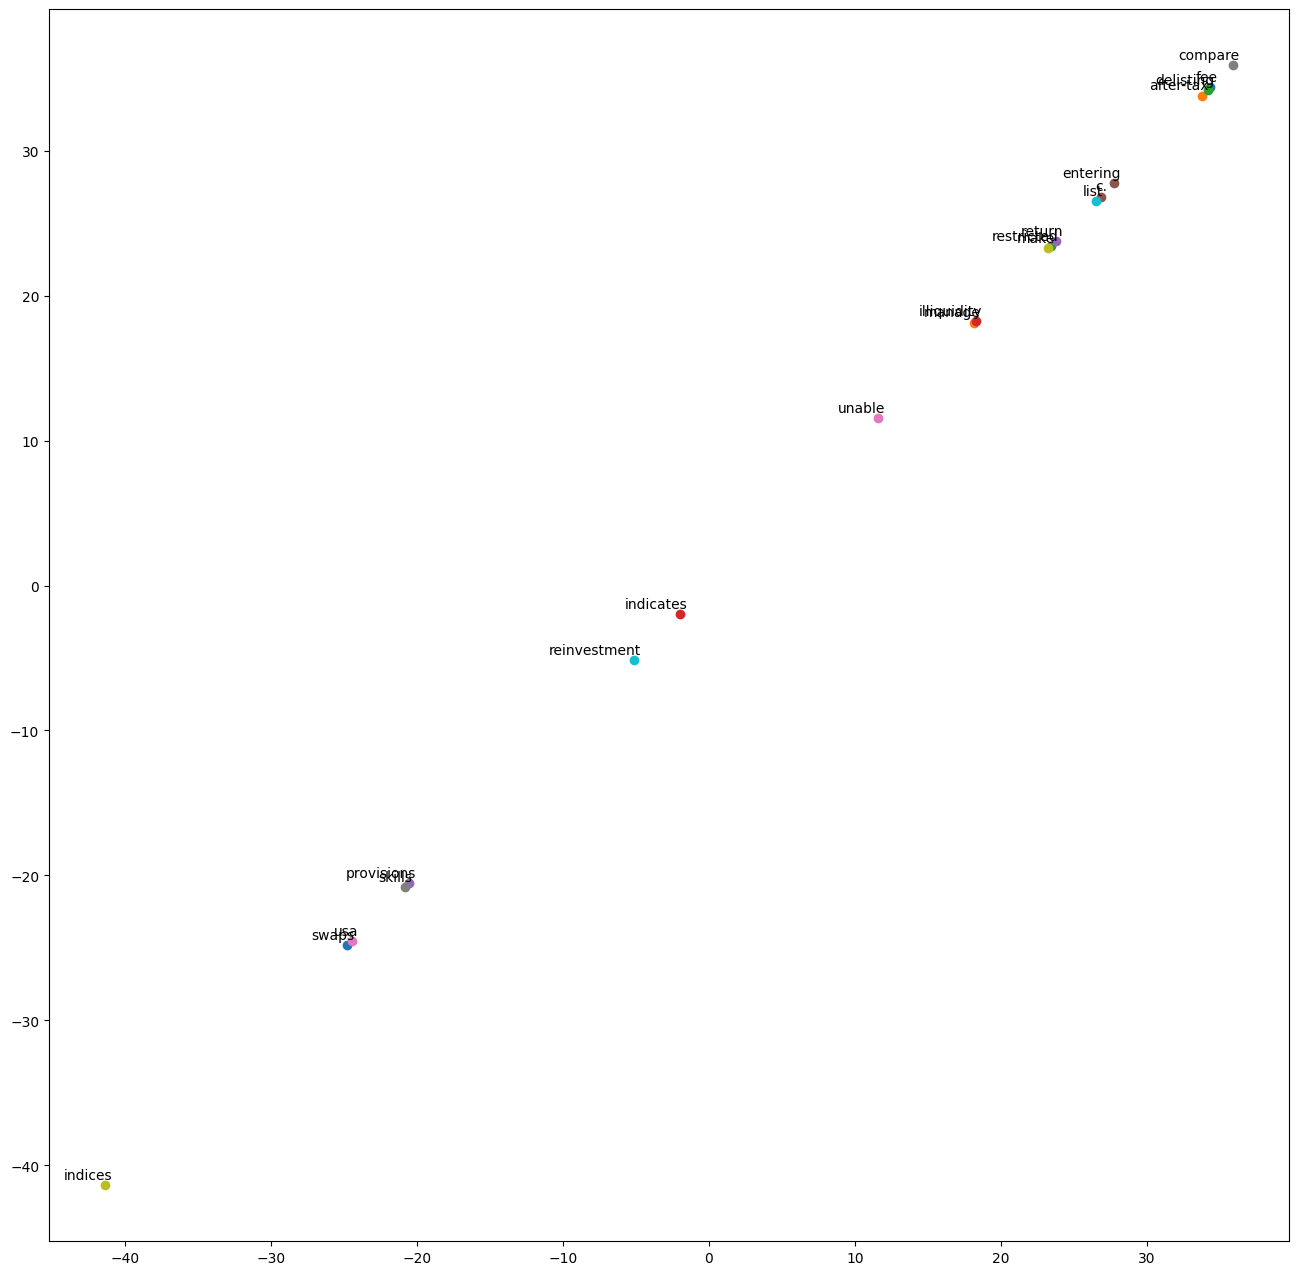

In [90]:
plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
plt.show()

## Create a knowledge base

In [91]:
key_words = ['balanced fund', 'fixed income', 'interest', 'bond', ' long only',
             'equity', 'low', 'risk', 'strategy', 'return', 'volatility', 'stock',
             'asset', 'class','growth','rebalance','diversification','leverage',
             ]

In [ ]:
#print(f"\nLoading dictionary from {file_path_pickle} using pickle...")
#with open('word2vec_model.pkl', 'rb') as f: # 'rb' means read binary
#    word2vec = pickle.load(f)
#print("Loading complete.")

In [56]:
#word2vec = load_word2vec(new_word2vec)

In [92]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [93]:
#word2vec = load_word2vec(our_word2vec)
knowledge_base = create_knowledge_base(5, word2vec, key_words)

balanced fund not in word2vec
fixed income not in word2vec
 long only not in word2vec


In [94]:
print(knowledge_base)

{np.str_('fidelity'), np.str_('excluding'), np.str_('capable'), np.str_('downside'), np.str_('face'), 'risk', np.str_('continued'), np.str_('themes'), np.str_('competitors'), np.str_('notes'), np.str_('level'), np.str_('measure'), 'rebalance', np.str_('thereby'), 'bond', np.str_('state-specific'), np.str_('five'), np.str_('terrorist'), np.str_('complexity'), np.str_('reflective'), np.str_('used'), 'diversification', np.str_('payout'), np.str_('contracts'), np.str_('r6'), np.str_('discussion'), np.str_('non-investment'), np.str_('governmental'), np.str_('normal'), np.str_('view'), np.str_('therefore'), np.str_('deferrals'), 'low', np.str_('administrators'), 'volatility', np.str_('ben/342-5236'), np.str_('passive'), 'leverage', np.str_('role'), np.str_('cornerstone'), np.str_('also'), 'equity', np.str_('wrap'), 'growth', np.str_('implementation'), np.str_('templeton'), np.str_('idi'), np.str_('attributes'), 'balanced fund', 'return', np.str_('contract'), np.str_('rely'), 'asset', np.str_

In [105]:
items_to_remove = {'balanced fund', 'fixed income', ' long only'}
for item in items_to_remove:
    knowledge_base.discard(item)
knowledge_base

{np.str_('529-e'),
 np.str_('administrators'),
 np.str_('also'),
 'asset',
 np.str_('attributes'),
 np.str_('ben/342-5236'),
 'bond',
 np.str_('capable'),
 np.str_('china'),
 'class',
 np.str_('competitors'),
 np.str_('complexity'),
 np.str_('continued'),
 np.str_('contract'),
 np.str_('contracts'),
 np.str_('cornerstone'),
 np.str_('deferrals'),
 np.str_('discussion'),
 np.str_('distress'),
 'diversification',
 np.str_('downside'),
 'equity',
 np.str_('european'),
 np.str_('excluding'),
 np.str_('face'),
 np.str_('fidelity'),
 np.str_('five'),
 np.str_('follow'),
 np.str_('gas'),
 np.str_('generate'),
 np.str_('governmental'),
 'growth',
 np.str_('idi'),
 np.str_('implementation'),
 np.str_('institutional'),
 'interest',
 np.str_('intermediate'),
 np.str_('level'),
 'leverage',
 np.str_('load'),
 'low',
 np.str_('measure'),
 np.str_('non-investment'),
 np.str_('normal'),
 np.str_('notes'),
 np.str_('parkway'),
 np.str_('passive'),
 np.str_('payout'),
 np.str_('r6'),
 'rebalance',
 np.

In [95]:
y_train[1]

'Vanguard Short-Term Treasury Fund'

In [96]:
df_summary[['fund_name','Prediction']]

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration,Ivestment_Strategy_label,Predicted investment strategy,investment strategy evidence,source meta data,Prediction
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2018 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2021 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2024 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2027 Fund <head_breaker...,{'source': 'MutualFundSummary1/American Funds ...,2.0
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,2.0,Balanced Fund (Low Risk),American Funds College 2030 Fund <head_breaker...,{'source': 'MutualFundSummary/American Funds C...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
427,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Corporate Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0
428,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,1.0,Fixed Income Long Only (Low Risk),American Century Diversified Municipal Bond ET...,{'source': 'MutualFundSummary/American Century...,1.0
429,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,0.0,Equity Long Only (Low Risk),American Century Quality Diversified Internati...,{'source': 'MutualFundSummary/American Century...,0.0
430,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,0.0,Equity Long Only (Low Risk),American Century STOXX U.S. Quality Growth ETF...,{'source': 'MutualFundSummary/American Century...,0.0


In [99]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction_train = pd.DataFrame({'fund_name' : y_train, 'summary':X_train})
df_label = df_summary[['fund_name','Prediction']]
df_main_train = df_label.merge(df_extraction_train, on='fund_name', how='inner')
df_main_train

,fund_name,Prediction,summary
0,American Funds College 2018 Fund,2.0,American Funds College 2018 Fund\n\nInvestment...
1,American Funds College 2021 Fund,2.0,American Funds College 2021 Fund\n\nInvestment...
2,American Funds College 2024 Fund,2.0,American Funds College 2024 Fund\n\nInvestment...
3,American Funds College 2033 Fund,2.0,American Funds College 2033 Fund\n\nInvestment...
4,American Funds College 2036 Fund,2.0,American Funds College 2036 Fund\n\nInvestment...
...,...,...,...
297,American Century Diversified Corporate Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...
298,American Century Diversified Municipal Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...
299,American Century Quality Diversified Internati...,0.0,Fund Summary\nInvestment Objective\nThe fund s...
300,American Century STOXX U.S. Quality Growth ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...


In [100]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction_val = pd.DataFrame({'fund_name' : y_val, 'summary':X_val})
df_label = df_summary[['fund_name','Prediction']]
df_main_val = df_label.merge(df_extraction_val, on='fund_name', how='inner')
df_main_val

,fund_name,Prediction,summary
0,American Funds College 2027 Fund,2.0,American Funds College 2027 Fund\n\nInvestment...
1,Bond Fund,1.0,Bond Fund\n\nInvestment objective The fund’s i...
2,Corporate Bond Fund,1.0,Investment objective The fund’s investment obj...
3,Global Bond Fund,1.0,Global Bond Fund\n\nInvestment objective The f...
4,Global Growth and Income Fund,2.0,Global Growth and Income Fund\n\nInvestment ob...
...,...,...,...
60,Franklin Payout 2022 Fund,1.0,Franklin Payout 2022 Fund\n\nInvestment Goal\n...
61,Fidelity Diversified International Fund,0.0,Fund Summary\n\nFund/Class:\nFidelity® Diversi...
62,Fidelity International Discovery Fund,0.0,Fund Summary\n\nFund/Class:\nFidelity® Interna...
63,Dreyfus Yield Enhancement Strategy Fund,1.0,Fund Summary\n\nInvestment Objective\nThe fund...


In [101]:
# We create here the dataframe tha contains the summaries along with their labels
df_extraction_test = pd.DataFrame({'fund_name' : y_test, 'summary':X_test})
df_label = df_summary[['fund_name','Prediction']]
df_main_test = df_label.merge(df_extraction_test, on='fund_name', how='inner')
df_main_test

,fund_name,Prediction,summary
0,American Funds College 2030 Fund,2.0,American Funds College 2030 Fund\n\nInvestment...
1,American Funds College Enrollment Fund,1.0,American Funds College Enrollment Fund\n\nInve...
2,American Funds U.S. Government Money Market Fund,1.0,Investment objective The investment objective ...
3,Global Balanced Fund,2.0,Global Balanced Fund\n\nInvestment objectives ...
4,Managed Risk Blue Chip Income and Growth Fund,2.0,Managed Risk Blue Chip Income and Growth Fund\...
...,...,...,...
60,Swan Defined Risk Fund,2.0,FUND SUMMARY – SWAN DEFINED RISK FUND\n\n \n\n...
61,Nasdaq-100 Index Fund,0.0,INVESTMENT OBJECTIVE\nThe USAA Nasdaq-100 Inde...
62,S&P 500 Index Fund,0.0,INVESTMENT OBJECTIVE\nThe USAA S&P 500 Index F...
63,Income Stock Fund,0.0,INVESTMENT OBJECTIVE\nThe USAA Income Stock Fu...


In [102]:
df_main_train['summary'] = df_main_train['summary'].astype(str)
df_main_val['summary'] = df_main_val['summary'].astype(str)
df_main_test['summary'] = df_main_test['summary'].astype(str)
df_main_train

,fund_name,Prediction,summary
0,American Funds College 2018 Fund,2.0,American Funds College 2018 Fund\n\nInvestment...
1,American Funds College 2021 Fund,2.0,American Funds College 2021 Fund\n\nInvestment...
2,American Funds College 2024 Fund,2.0,American Funds College 2024 Fund\n\nInvestment...
3,American Funds College 2033 Fund,2.0,American Funds College 2033 Fund\n\nInvestment...
4,American Funds College 2036 Fund,2.0,American Funds College 2036 Fund\n\nInvestment...
...,...,...,...
297,American Century Diversified Corporate Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...
298,American Century Diversified Municipal Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...
299,American Century Quality Diversified Internati...,0.0,Fund Summary\nInvestment Objective\nThe fund s...
300,American Century STOXX U.S. Quality Growth ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...


In [103]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [106]:
# It takes several minutes (5-10 minutes)
df_main_train['strategy_sentences_distance'] = df_main_train.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [ ]:
#def extract_sentence_match(summary, knowledge, num_sent):
#    sentences = sent_tokenize(summary)
#    sentence_scores = []
#    for j, sentence in enumerate(sentences):
#        set_tokens = set(tokenizer(sentence))
#
        # Find the number of common words between the knowledge base and the sentence
 #       inter_knwoledge = set_tokens.intersection(knowledge)
#
 #       sentence_scores.append(len(inter_knwoledge))
#
 #   sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
  #  top_sentences = sentences[len(sentences)-num_sent-1:]
   # return ' '.join(top_sentences)

In [ ]:
#df_main['strategy_sentences_match'] = df_main.apply(lambda x : extract_sentence_match(x['Summary'], knowledge_base, num_sent=5), axis=1)

In [108]:
df_main_train

,fund_name,Prediction,summary,strategy_sentences_distance
0,American Funds College 2018 Fund,2.0,American Funds College 2018 Fund\n\nInvestment...,Bonds and other debt securities are also subje...
1,American Funds College 2021 Fund,2.0,American Funds College 2021 Fund\n\nInvestment...,Bonds and other debt securities are also subje...
2,American Funds College 2024 Fund,2.0,American Funds College 2024 Fund\n\nInvestment...,Bonds and other debt securities are also subje...
3,American Funds College 2033 Fund,2.0,American Funds College 2033 Fund\n\nInvestment...,Bonds and other debt securities are also subje...
4,American Funds College 2036 Fund,2.0,American Funds College 2036 Fund\n\nInvestment...,Bonds and other debt securities are also subje...
...,...,...,...,...
297,American Century Diversified Corporate Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...,Although the fund invests primarily in investm...
298,American Century Diversified Municipal Bond ETF,1.0,Fund Summary\nInvestment Objective\nThe fund s...,When determining whether to buy or sell a secu...
299,American Century Quality Diversified Internati...,0.0,Fund Summary\nInvestment Objective\nThe fund s...,•\nIndex-Related Risk - Unlike many investmen...
300,American Century STOXX U.S. Quality Growth ETF,0.0,Fund Summary\nInvestment Objective\nThe fund s...,•\nIndex-Related Risk - Unlike many investmen...


## Information extraction using deep classifiers

In [110]:
#X = df_main['strategy_sentences_match'].values
X_train = df_main_train['strategy_sentences_distance'].values # uncomment to use the first sentence extraction method.
# Clean the texts
X_train = [' '.join(tokenizer(txt)) for txt in X_train]
X_train[0][:100]

'bonds debt securities also subject credit risk possibility credit strength issuer weaken and/or issu'

In [111]:
y_train = df_main_train['Prediction']
y_train

,Prediction
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
297,1.0
298,1.0
299,0.0
300,0.0


In [133]:
y_val = df_main_val['Prediction']
y_val

,Prediction
0,2.0
1,1.0
2,1.0
3,1.0
4,2.0
...,...
60,1.0
61,0.0
62,0.0
63,1.0


In [134]:
y_test = df_main_test['Prediction']
y_test

,Prediction
0,2.0
1,1.0
2,1.0
3,2.0
4,2.0
...,...
60,2.0
61,0.0
62,0.0
63,0.0


## Data Pre-Processing

<ipython-input-114-bc141d98f3b4>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes, kde=False, rug=True)


<Axes: >

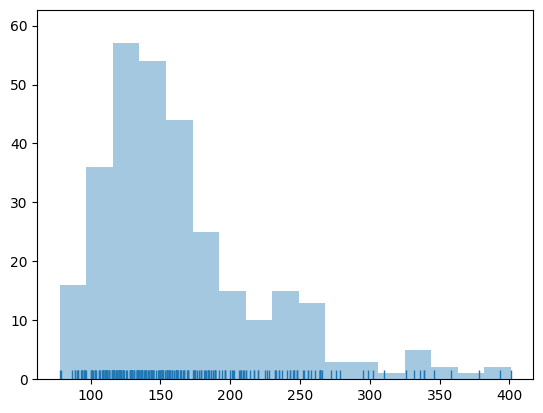

In [114]:
# In order to set the length of the document series (maxlen), we visualise the distribution of the number of words per documents.
sizes = []
out = display(progress(0, len(X_train)), display_id=True)
for ii, txt in enumerate(X_train):
    sizes.append(len(word_tokenize(txt)))
    out.update(progress(ii, len(X_train)))

sns.distplot(sizes, kde=False, rug=True)

In [115]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 170 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [118]:
# The Tokenizer provided by the Keras library allows to perform such transformation.
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(X_train)
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
word_index = keras_tokenizer.word_index
sequences_train = keras_tokenizer.texts_to_sequences(X_train)
sequences_val = keras_tokenizer.texts_to_sequences(X_val)

In [119]:
print('Text : '+X_train[0])
print('Index sequences : ' +str(sequences_train[0]))

Text : bonds debt securities also subject credit risk possibility credit strength issuer weaken and/or issuer debt security fail make timely payments principal interest security go default investing lower rated debt instruments lower rated bonds lower rated debt securities generally higher rates interest involve greater risk default price declines due changes issuer creditworthiness higher quality debt securities aggregate index reflects deductions sales charges account fees expenses u.s. federal income taxes american funds college target date series prospectus management investment adviser capital research management companysm portfolio oversight committee investment adviser portfolio oversight committee develops allocation approach selects underlying funds fund invests box indianapolis indiana telephoning american funds service company faxing american funds service company accessing website americanfunds.com underlying funds may also invest debt securities governments agencies corpor

In [121]:
#Then we use the pad_sequence function provided by keras to truncate or lengthen (by adding zeros)
#each text so they all have the same length : 170
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_val = pad_sequences(sequences_val, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [122]:
print ('length of the first sequence : '+str(len(sequences_train[0])) )
print ('length of the paded first sequence : '+str(len(feature_train[0])) )

length of the first sequence : 132
length of the paded first sequence : 170


In [124]:
#matrix representation of the words in our vocabulary
# word_index is the dictionary that contains the index of each words in our 2500 long vocabulary.
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [125]:
embedding_matrix[2]

array([-0.50577933, -0.52013403,  0.47766995,  0.53183913,  0.45137578,
       -0.51973385, -0.4623442 ,  0.45508343, -0.50029629, -0.51723653,
        0.53489703, -0.53055692, -0.4895969 , -0.4390125 , -0.47497186,
        0.53666115, -0.50730366, -0.50142318,  0.49996787,  0.46795484,
        0.45045799, -0.47033012,  0.51073945, -0.43978727, -0.43818417,
        0.52715021, -0.45496988,  0.48179051,  0.53658473, -0.50982106,
       -0.517416  ,  0.46189827, -0.52312732,  0.52484125, -0.50481033,
        0.5023554 ,  0.48952204,  0.48896426,  0.4525879 ,  0.52572048,
        0.47960424, -0.46840718, -0.43233094, -0.47225112, -0.46972334,
        0.5041995 ,  0.51556063, -0.47897217,  0.52395344, -0.45740405])

In [126]:
embedding_matrix.shape

(2437, 50)

In [127]:
len(word_index) + 1

2437

In [128]:
word_dimension

50

## First model: One dimensional Convolutional Neural Network

In [129]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length=maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 1, activation = 'sigmoid'))

    CNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return CNN

In [130]:
CNN_model = create_CNN_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [135]:
CNN_history = CNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.3235 - loss: 0.6268 - val_accuracy: 0.3231 - val_loss: 0.5993
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3142 - loss: 0.6017 - val_accuracy: 0.3231 - val_loss: 0.6069
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2810 - loss: 0.6090 - val_accuracy: 0.3231 - val_loss: 0.5926
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2668 - loss: 0.5503 - val_accuracy: 0.3231 - val_loss: 0.5984
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3007 - loss: 0.5914 - val_accuracy: 0.3231 - val_loss: 0.6099
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2921 - loss: 0.5908 - val_accuracy: 0.3231 - val_loss: 0.5973
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2890 - loss: 0.4978 - val_accuracy: 0.3231 - val_loss: 0.5953
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3392 - loss: 0.5246 - val_accuracy: 0.3231 - val_lo

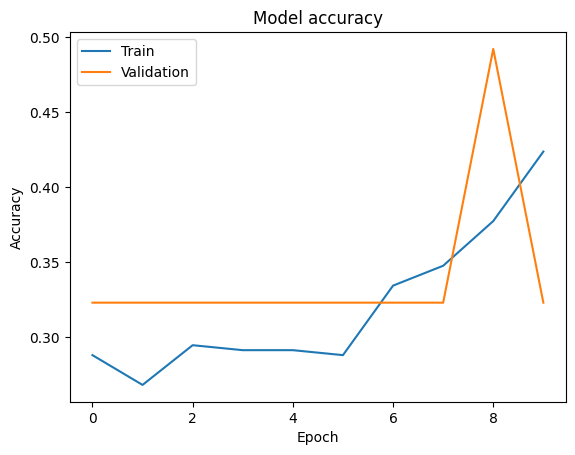

In [136]:
# Plot training & validation accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

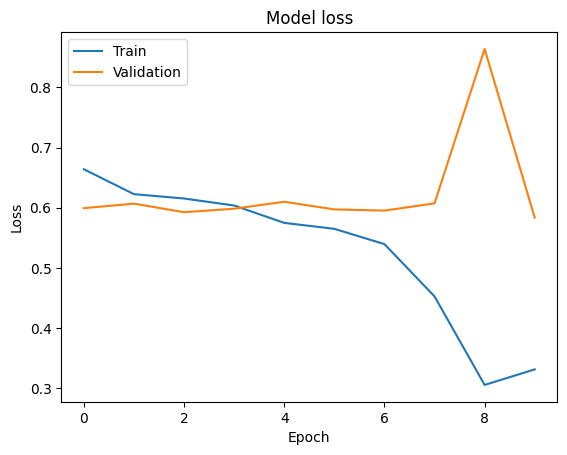

In [137]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [138]:
y_pred_CNN = CNN_model.predict(feature_val)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


In [139]:
fpr, tpr, threshold =roc_curve(y_val, y_pred_CNN)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ValueError: multiclass format is not supported

## Second Model

In [140]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(1, activation='sigmoid'))
    RNN.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return RNN

In [142]:
RNN_model = create_RNN_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [143]:
RNN_history = RNN_model.fit(feature_train, y_train, epochs=10, batch_size=16, validation_data=(feature_val, y_val))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.2577 - loss: 0.6332 - val_accuracy: 0.3231 - val_loss: 0.5938
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2823 - loss: 0.5729 - val_accuracy: 0.3231 - val_loss: 0.5920
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2710 - loss: 0.6096 - val_accuracy: 0.3231 - val_loss: 0.5955
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2803 - loss: 0.5297 - val_accuracy: 0.3231 - val_loss: 0.5953
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2744 - loss: 0.6545 - val_accuracy: 0.3231 - val_loss: 0.5908
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2433 - loss: 0.6502 - val_accuracy: 0.3231 - val_loss: 0.5898
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2782 - loss: 0.6131 - val_accuracy: 0.3231 - val_loss: 0.5916
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2735 - loss: 0.5346 - val_accuracy: 0.3231 - v

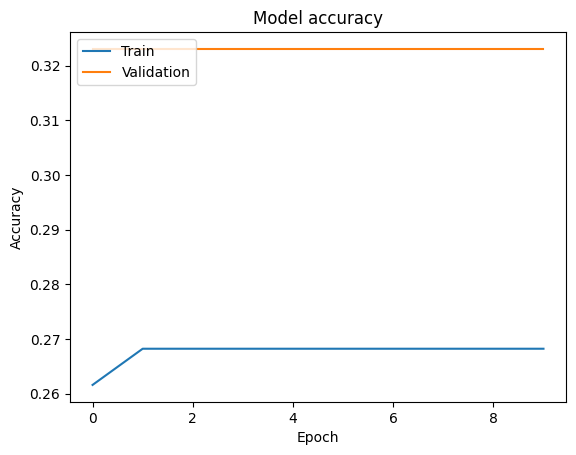

In [144]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()